In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import sys
import os

sys.path.append(os.path.abspath("../scripts"))
export_path = "../data/togo-dapaong_qc_clean.csv"

from clean_data import clean_data
from remove_outliers import remove_outliers_iqr

path = "../data/togo-dapaong_qc.csv"
df = pd.read_csv(path)

In [2]:
#brief summary
df.describe()
print("columns", df.columns.tolist())
df.head()
df.dtypes
total = len(df)
print(total)

columns ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']
525600


In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

In [4]:
#number of missing 
missing = df.isna().sum()
print(missing[missing > 0])

Comments    525600
dtype: int64


In [5]:
percentage = (missing / len(df)) * 100
missing_report = pd.DataFrame({"Missing": missing, "Percentage": percentage})
print(missing_report)
print(missing_report[missing_report["Percentage"] > 5])

               Missing  Percentage
Timestamp            0         0.0
GHI                  0         0.0
DNI                  0         0.0
DHI                  0         0.0
ModA                 0         0.0
ModB                 0         0.0
Tamb                 0         0.0
RH                   0         0.0
WS                   0         0.0
WSgust               0         0.0
WSstdev              0         0.0
WD                   0         0.0
WDstdev              0         0.0
BP                   0         0.0
Cleaning             0         0.0
Precipitation        0         0.0
TModA                0         0.0
TModB                0         0.0
Comments        525600       100.0
Hour                 0         0.0
Day                  0         0.0
Month                0         0.0
Year                 0         0.0
DayOfWeek            0         0.0
          Missing  Percentage
Comments   525600       100.0


In [6]:
columns = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
duplicate_count = df.duplicated().sum()
print('Duplicate count', duplicate_count)


Duplicate count 0


In [7]:
print("Negative Counts")
print((df[['GHI', 'DNI', 'DHI']] < 0).sum())


Negative Counts
GHI    257385
DNI         0
DHI         0
dtype: int64


In [9]:
z_scores = df[columns].apply(zscore)
outlier_flags = (np.abs(z_scores) > 3)
outlier_counts_per_col = outlier_flags.sum()
print(outlier_counts_per_col)

GHI          5
DNI          0
DHI        182
ModA         0
ModB         2
WS        1033
WSgust    1177
dtype: int64


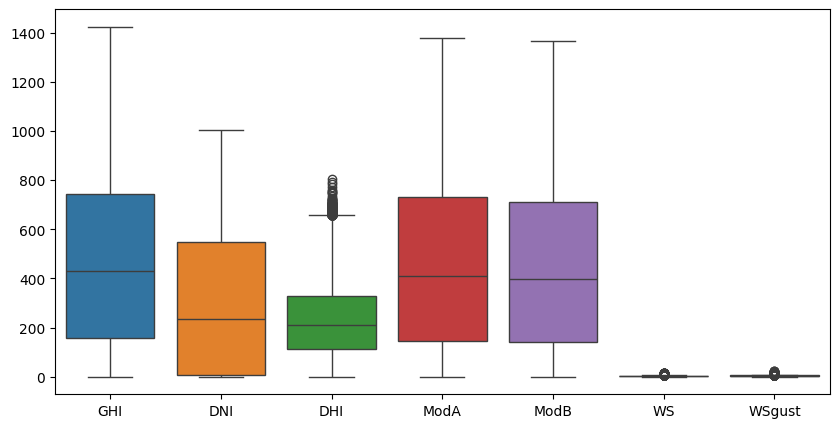

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[columns])
plt.show()

In [11]:
#Cleaning Scrpt can be found in Scripts/clean_data
df_clean = clean_data(df)

In [12]:
#Drop rows with negative irradiance values
df = df[(df[['GHI', 'DNI', 'DHI']] >= 0).all(axis=1)]

In [ ]:
# Removal script in scripts/remove_outliers
columns = ['ModA', 'ModB', 'WS', 'WSgust', 'DNI', 'DHI', 'GHI']
df_no_outliers = remove_outliers_iqr(df_clean.copy(), columns)


In [13]:
df_clean.to_csv(export_path, index=False)

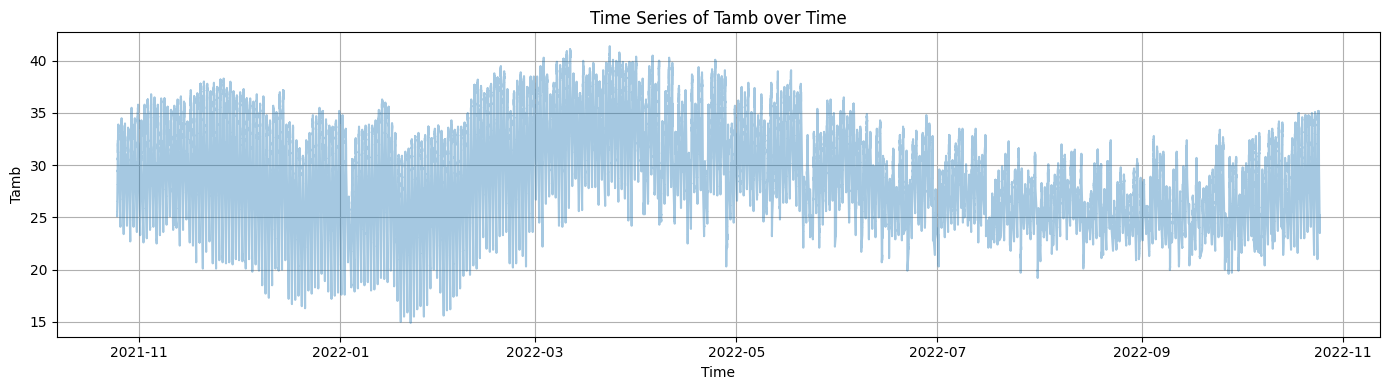

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(df['Timestamp'], df['Tamb'], alpha=0.4)
plt.title(f'Time Series of Tamb over Time')
plt.xlabel('Time')
plt.ylabel('Tamb')
plt.grid(True)
plt.tight_layout()
plt.show()

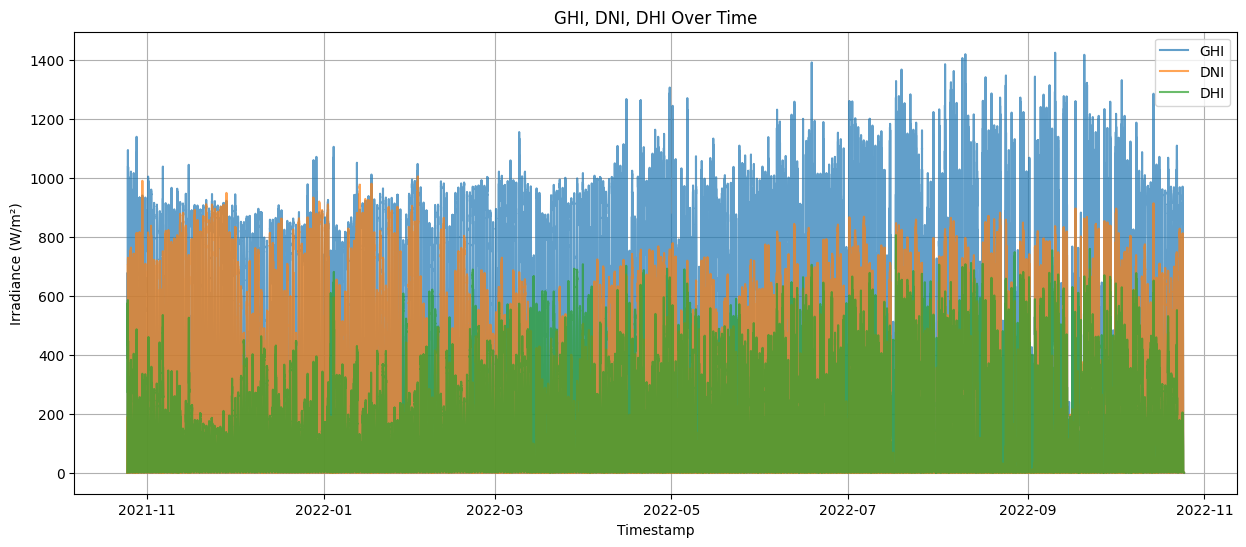

In [15]:
plt.figure(figsize=(15, 6))

plt.plot(df['Timestamp'], df['GHI'], label='GHI', alpha=0.7)
plt.plot(df['Timestamp'], df['DNI'], label='DNI', alpha=0.7)
plt.plot(df['Timestamp'], df['DHI'], label='DHI', alpha=0.7)

plt.title('GHI, DNI, DHI Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/mÂ²)')
plt.legend()
plt.grid(True)
plt.show()

['GHI', 'DHI', 'DNI']


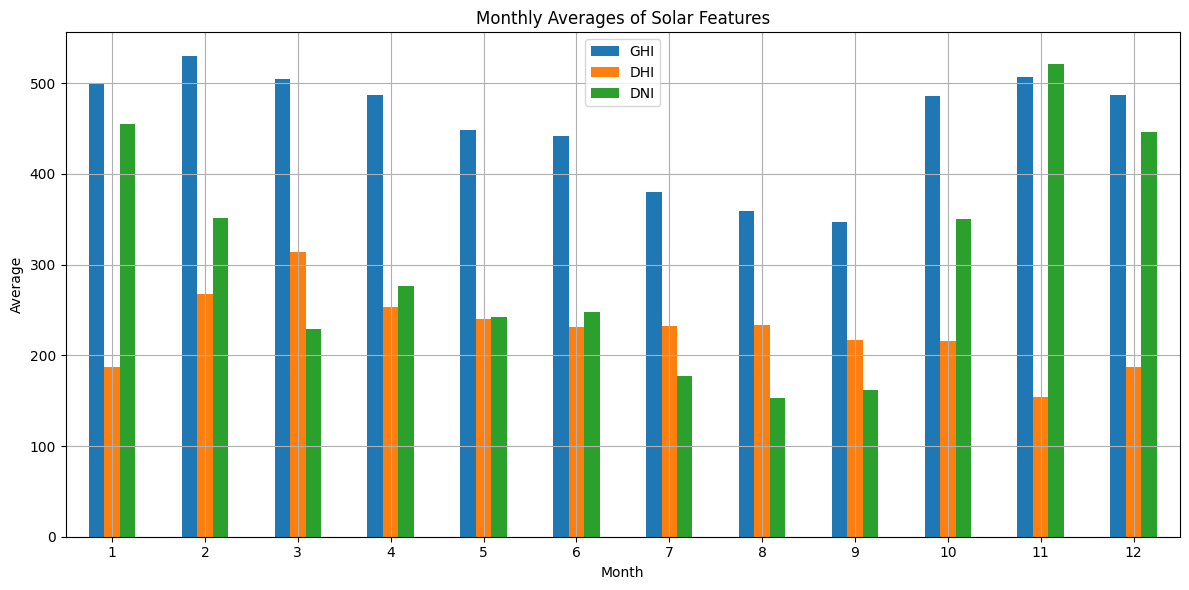

In [16]:
cols = ['GHI', 'DHI', 'DNI']
monthly_avg = df.groupby('Month')[cols].mean()
print(cols)

monthly_avg.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Averages of Solar Features')
plt.ylabel('Average')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


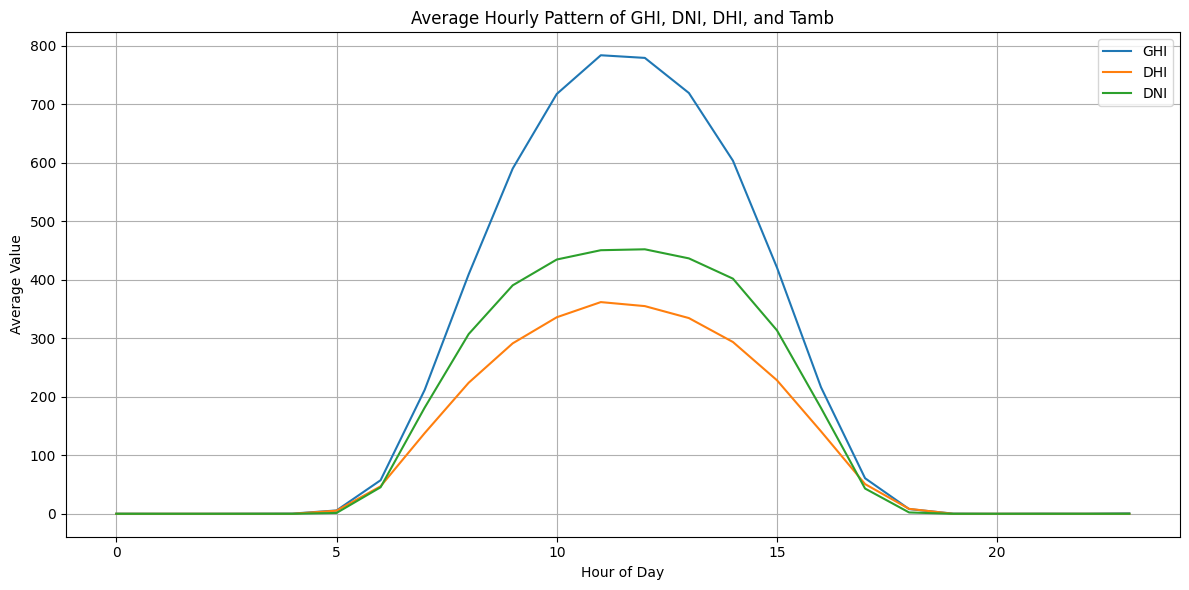

In [17]:
hourly_avg = df.groupby('Hour')[cols].mean()

hourly_avg.plot(figsize=(12,6))
plt.title('Average Hourly Pattern of GHI, DNI, DHI, and Tamb')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()


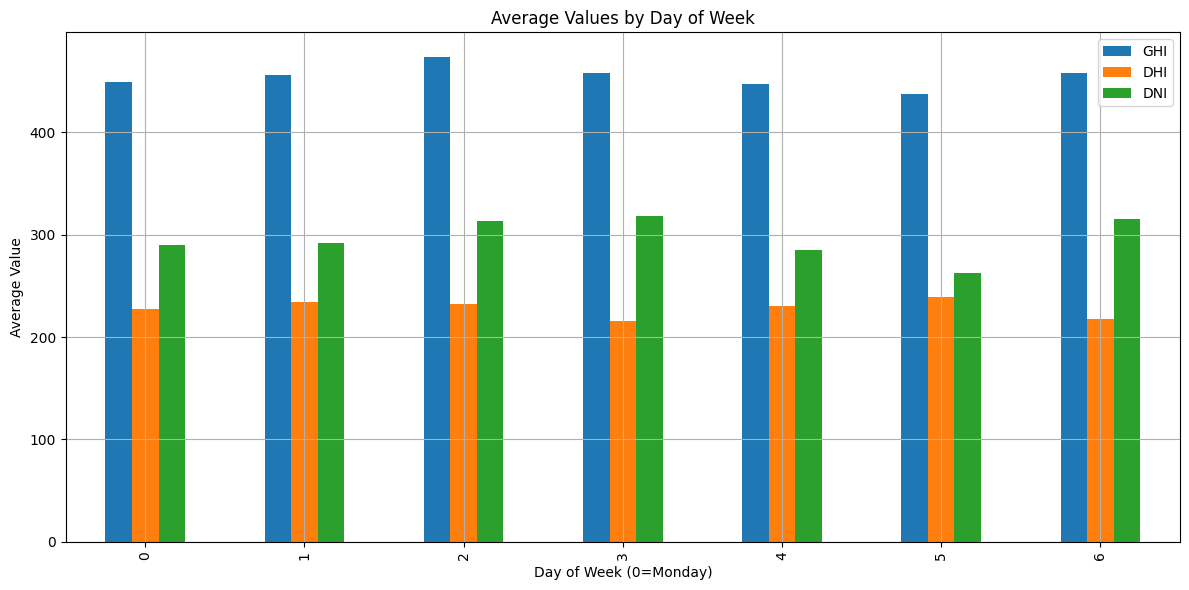

In [18]:
week_avg = df.groupby('DayOfWeek')[cols].mean()

week_avg.plot(kind='bar', figsize=(12,6))
plt.title('Average Values by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()


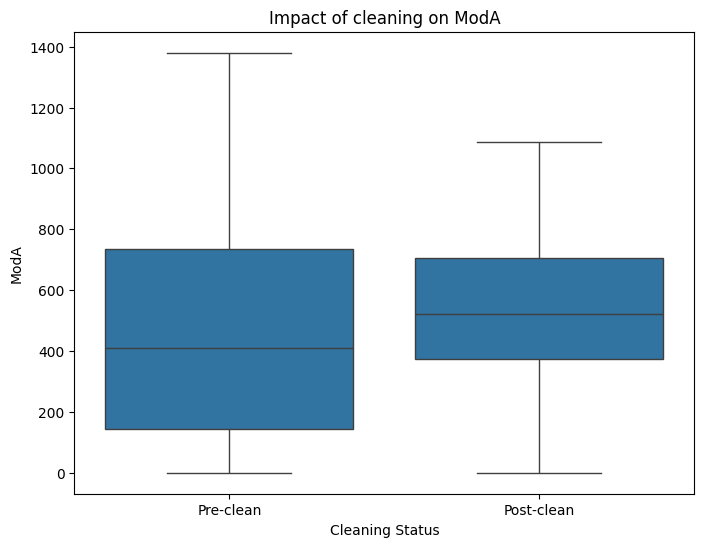

In [19]:

pre_clean = df[df['Cleaning'] == 0]['ModA']
post_clean = df[df['Cleaning'] == 1]['ModA']

combined = pd.DataFrame({
    'ModA': pd.concat([pre_clean, post_clean], ignore_index=True),
    'Cleaning Status': ['Pre-clean'] * len(pre_clean) + ['Post-clean'] * len(post_clean)
})
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined, x='Cleaning Status', y='ModA')
plt.title('Impact of cleaning on ModA')
plt.show()

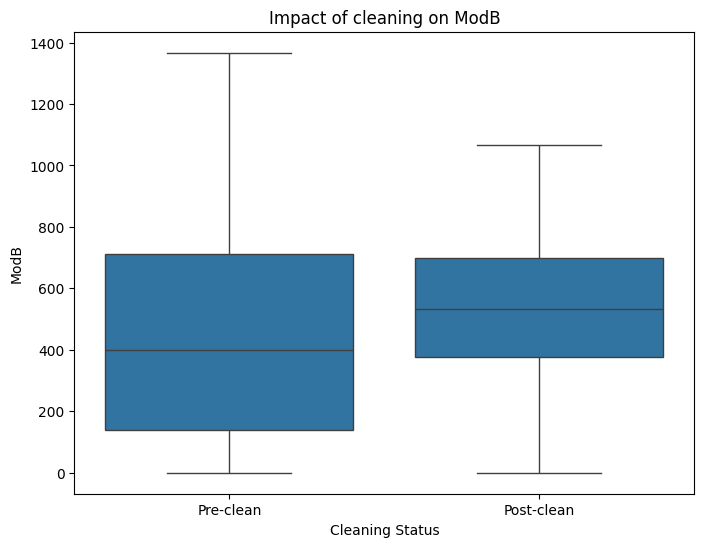

In [20]:
pre_clean = df[df['Cleaning'] == 0]['ModB']
post_clean = df[df['Cleaning'] == 1]['ModB']

combined = pd.DataFrame({
    'ModB': pd.concat([pre_clean, post_clean], ignore_index=True),
    'Cleaning Status': ['Pre-clean'] * len(pre_clean) + ['Post-clean'] * len(post_clean)
})
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined, x='Cleaning Status', y='ModB')
plt.title('Impact of cleaning on ModB')
plt.show()

<Axes: >

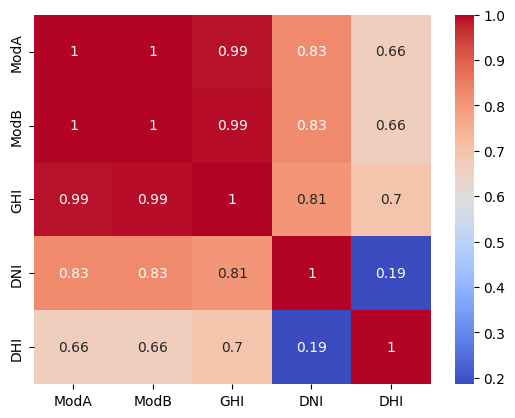

In [21]:
mod_corr = df[['ModA', 'ModB', 'GHI', 'DNI', 'DHI']].corr()
sns.heatmap(mod_corr, annot=True, cmap="coolwarm")

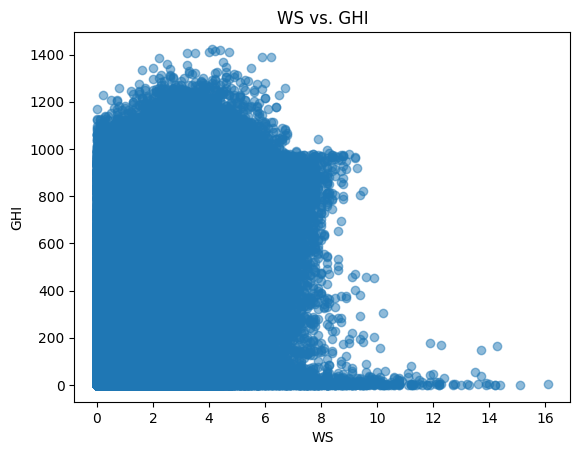

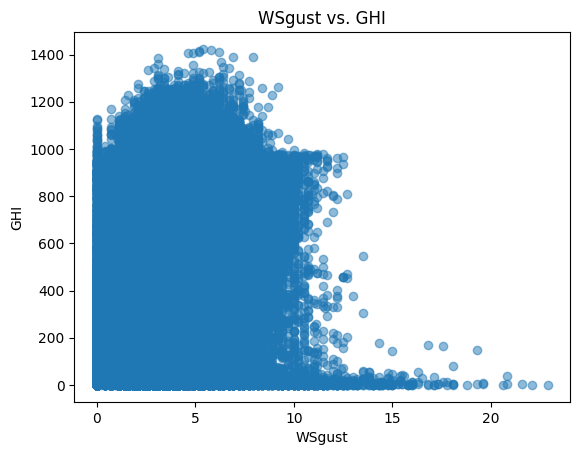

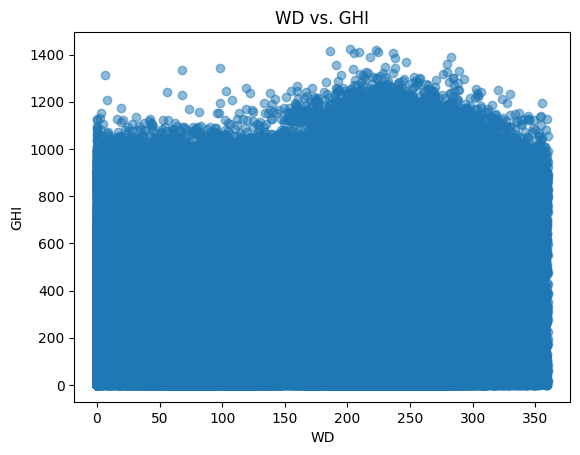

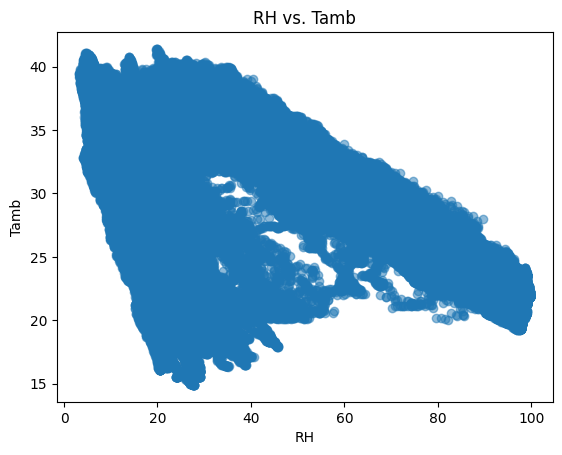

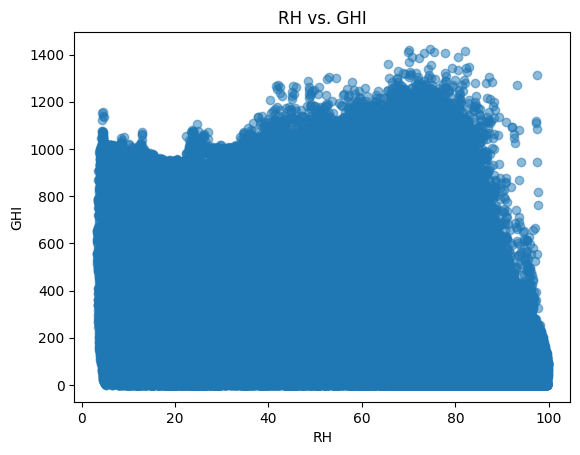

In [22]:
pairs = [
    ('WS', 'GHI'), ('WSgust', 'GHI'), ('WD', 'GHI'),
    ('RH', 'Tamb'), ('RH', 'GHI')
]
df_clean = df.copy()
for x, y in pairs:
    plt.figure()
    plt.scatter(df_clean[x], df_clean[y], alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y}")

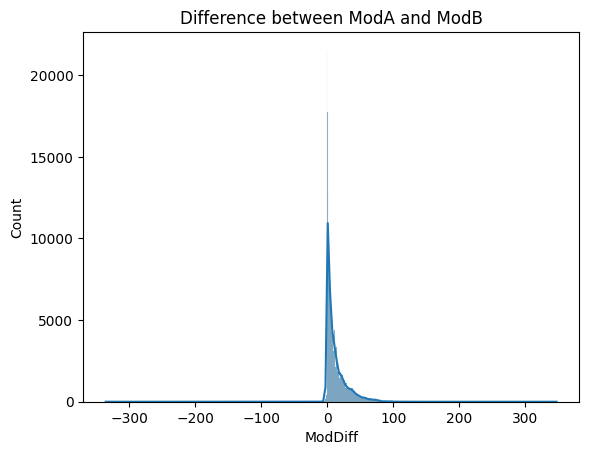

In [23]:
df['ModDiff'] = df['ModA'] - df['ModB']
sns.histplot(df['ModDiff'], kde=True)
plt.title("Difference between ModA and ModB")
plt.show()


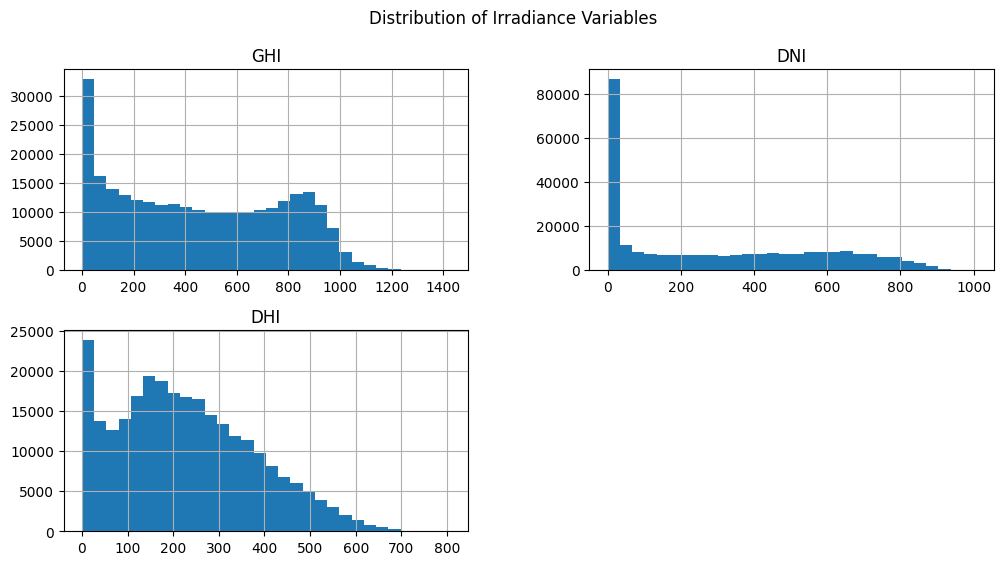

In [24]:
df[['GHI', 'DNI', 'DHI']].hist(bins=30, figsize=(12, 6))
plt.suptitle("Distribution of Irradiance Variables")
plt.show()

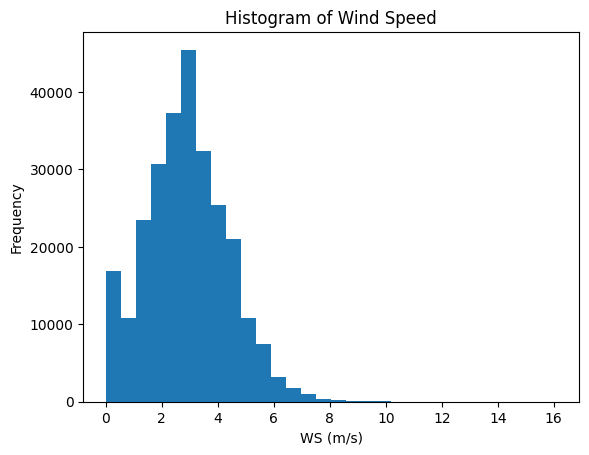

In [25]:
plt.figure()
plt.hist(df_clean['WS'].dropna(), bins=30)
plt.title('Histogram of Wind Speed')
plt.xlabel('WS (m/s)')
plt.ylabel('Frequency')
plt.show()

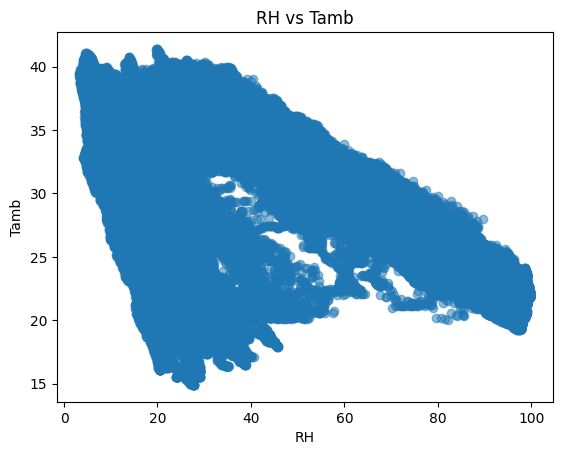

In [26]:
plt.figure()
plt.scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
plt.xlabel('RH')
plt.ylabel('Tamb')
plt.title('RH vs Tamb')
plt.show()

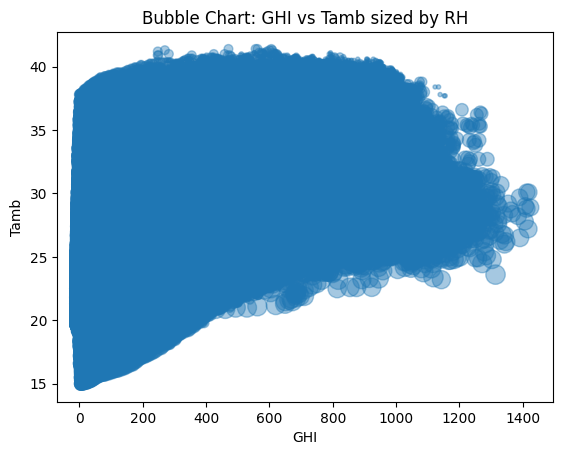

In [27]:
plt.figure()
plt.scatter(df_clean['GHI'], df_clean['Tamb'],
            s=df_clean['RH'] / df_clean['RH'].max() * 200, alpha=0.4)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('Bubble Chart: GHI vs Tamb sized by RH')
plt.show()